# Introduction
I evaluate the performance of a number of short rate forecasting models (Vasicek, CIR, Random Forest, Gated Recurrent Unit (GRU)) compared to a Random Walk baseline. I find that the CIR and Vasicek models outperform the Random Walk baseline for 1-step and 7-step ahead forecasts, while Random Forest and GRU consistently underperform

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU

In [ ]:
df = pd.read_excel('treasury_bill_data.xlsx', index_col='Date')

In [3]:
dates = df.index
US_ir = df.Close / 100
US_ir.head()

Date
2021-08-06    0.00043
2021-08-09    0.00045
2021-08-10    0.00050
2021-08-11    0.00045
2021-08-12    0.00043
Name: Close, dtype: float64

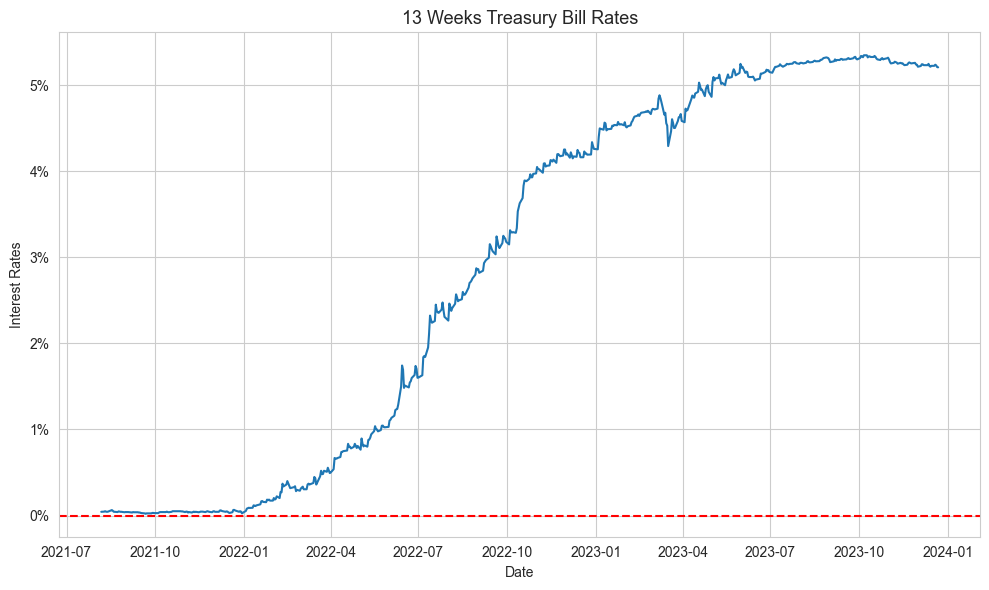

In [4]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.lineplot(data=US_ir)
plt.xlabel('Date')
plt.ylabel('Interest Rates')
plt.title('13 Weeks Treasury Bill Rates', fontsize=13)
plt.grid(True)
def percentage(x, pos):
    return f'{x:.0%}'  
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(percentage))
plt.axhline(y=0, color='red', linestyle='--')  
plt.tight_layout()
plt.show()

# Random Walk

$i_{t+\delta t} = i_{t} + \epsilon$

- Where $\epsilon$ represents a disturbance term with zero mean.

This formulation enables the use of the Random Walk as a basic martingale benchmark, where the optimal prediction for rates at time $t+1$ is simply the rates at time $t$

In [ ]:
df = US_ir.copy()
df = pd.DataFrame({'series1': df})
df = df.join(US_ir.shift(1),  how='left')
df.columns = ['rates t', 'rates t-1']
df = df.dropna()
df.reset_index(inplace=True)
df = df.iloc[:, 1:]
print(df.head())

y = df['rates t']
X = df[['rates t-1']]

   rates t  rates t-1
0  0.00045    0.00043
1  0.00050    0.00045
2  0.00045    0.00050
3  0.00043    0.00045
4  0.00045    0.00043


In [ ]:
# Important variables
ts_length = df.shape[0]
n_obs = 90
max_time_step = 90
dt = 1/252

pred1_v = np.zeros(ts_length-(n_obs+max_time_step-1))
pred7_v = np.zeros(ts_length-(n_obs+max_time_step-1))
pred30_v = np.zeros(ts_length-(n_obs+max_time_step-1))
pred90_v = np.zeros(ts_length-(n_obs+max_time_step-1))

"""
create a loop for the rolling window, but only for those
timeframes where backtesting is possible
"""
for n in range(ts_length-n_obs):

    X_train = X.iloc[n:n+n_obs, :]
    y_train = y.iloc[n:n+n_obs]
    prediction_index = y_train.index[-1]

    # Need to break the loop if my max prediction cannot be backtested
    if (prediction_index + max_time_step) > y.index[-1]:
        break

    r0 = y_train.iloc[-1]

    pred1 = r0
    pred7 = r0
    pred30 = r0
    pred90 = r0

    exact1 = y.iloc[prediction_index + 1]
    exact7 = y.iloc[prediction_index + 7]
    exact30 = y.iloc[prediction_index + 30]
    exact90 = y.iloc[prediction_index + 90]

    # Store the predictions and the exact values
    pred1_v[n] = pred1
    pred7_v[n] = pred7
    pred30_v[n] = pred30
    pred90_v[n] = pred90

    exact1_v[n] = exact1
    exact7_v[n] = exact7
    exact30_v[n] = exact30
    exact90_v[n] = exact90

In [ ]:
# Create a dataframe with all the predictions and one with all exact values
pred_RW = {
    '1 step pred': pred1_v,
    '7 step pred': pred7_v,
    '30 step pred': pred30_v,
    '90 step pred': pred90_v
}

exact_rates = {
    '1 step exact': exact1_v,
    '7 step exact': exact7_v,
    '30 step exact': exact30_v,
    '90 step exact': exact90_v
}

pred_RW = pd.DataFrame(pred_RW)
exact_rates = pd.DataFrame(exact_rates)
pred_RW.index = dates[n_obs:pred_RW.shape[0]+n_obs]
exact_rates.index = dates[n_obs:pred_RW.shape[0]+n_obs]

# Compute MSE
SE_RW = pd.DataFrame(columns=['1 step ahead', '7 steps ahead', '30 steps ahead', '90 steps ahead'])
for n in range(4):
    SE_RW[SE_RW.columns[n]] = (pred_RW.iloc[:, n] - exact_rates.iloc[:, n])**2
    
SE_RW.describe()

,1 step ahead,7 steps ahead,30 steps ahead,90 steps ahead
count,4.200000e+02,4.200000e+02,4.200000e+02,4.200000e+02
mean,3.200209e-07,2.578023e-06,2.274667e-05,1.691888e-04
std,8.034475e-07,6.000665e-06,3.139453e-05,1.837303e-04
min,0.000000e+00,0.000000e+00,2.500114e-09,2.499638e-09
25%,6.400020e-09,1.072751e-07,2.146300e-06,2.423117e-05
50%,4.840138e-08,5.929002e-07,9.363700e-06,7.056487e-05
75%,2.303986e-07,2.310398e-06,3.197911e-05,3.092323e-04
max,6.002500e-06,5.183999e-05,1.729225e-04,6.786024e-04


# Vasicek Model

I use the deterministic approximation $r_t = r_0 \cdot e^{-kt} + \theta \cdot \left(1 - e^{-kt}\right)$ to forecast short rates for 1- 7- 30- and 90-day ahead.

To find k and $\theta$ I fit linear regression


In [15]:
pred1_v = np.zeros(ts_length-(n_obs+max_time_step-1))
pred7_v = np.zeros(ts_length-(n_obs+max_time_step-1))
pred30_v = np.zeros(ts_length-(n_obs+max_time_step-1))
pred90_v = np.zeros(ts_length-(n_obs+max_time_step-1))

for n in range(ts_length-n_obs):
    
    model = LinearRegression()

    X_train = X.iloc[n:n+n_obs, :]
    y_train = y.iloc[n:n+n_obs]
    prediction_index = y_train.index[-1]

    # Need to break the loop if my max prediction cannot be backtested
    if (prediction_index + max_time_step) > y.index[-1]:
        break

    model.fit(X_train, y_train)

    intercept = model.intercept_
    slope = model.coef_[0]

    # Get the parameter of interest for Vasicek
    k = (1-slope)/dt
    theta = intercept / (1-slope)

    # Pedictions at 4 time steps
    r0 = y.iloc[prediction_index]

    pred1 = r0 * np.exp(-k*dt) + theta * (1 - np.exp(-k*dt))
    pred7 = r0 * np.exp(-k*7*dt) + theta * (1 - np.exp(-k*7*dt))
    pred30 = r0 * np.exp(-k*30*dt) + theta * (1 - np.exp(-k*30*dt))
    pred90 = r0 * np.exp(-k*90*dt) + theta * (1 - np.exp(-k*90*dt))

    # Store the predictions
    pred1_v[n] = pred1
    pred7_v[n] = pred7
    pred30_v[n] = pred30
    pred90_v[n] = pred90

In [ ]:
# Create a dataframe with all the predictions
pred_vsk = {
    '1 step pred': pred1_v,
    '7 step pred': pred7_v,
    '30 step pred': pred30_v,
    '90 step pred': pred90_v
}

pred_VSK = pd.DataFrame(pred_vsk)
pred_VSK.index = dates[n_obs:pred_RW.shape[0]+n_obs]

# Compute MSE
SE_VSK = pd.DataFrame(columns=['1 step ahead', '7 steps ahead', '30 steps ahead', '90 steps ahead'])
for n in range(4):
    SE_VSK[SE_VSK.columns[n]] = (pred_VSK.iloc[:, n] - exact_rates.iloc[:, n])**2

SE_VSK.describe()

,1 step ahead,7 steps ahead,30 steps ahead,90 steps ahead
count,4.200000e+02,4.200000e+02,4.200000e+02,4.200000e+02
mean,3.170212e-07,2.359788e-06,2.342957e-05,3.766314e-01
std,7.508250e-07,5.416998e-06,1.212859e-04,7.428566e+00
min,2.513944e-14,6.968489e-12,1.844309e-11,5.211745e-08
25%,9.170760e-09,1.724598e-07,1.308826e-06,8.085698e-06
50%,5.794713e-08,5.413945e-07,4.582203e-06,3.109036e-05
75%,2.490360e-07,1.885082e-06,1.487130e-05,9.816365e-05
max,6.670697e-06,4.035466e-05,2.194620e-03,1.521947e+02


# CIR 

I first set the transformation `y_cir` to map the target to a linear form based on the rates and their square roots, then I find `z1` and `z2` corresponding respectively to the rate of change of interest rate and term capturing volatility of the CIR model (i.e. the square root of `X_train`). After this I fit a linear regression to extract the coefficients $\beta_1$ and $\beta_2$. Finally I forecast the short rates for multiple time horizons using the discretized formula $r_t = r_0 \cdot e^{-kt} + \theta \cdot \left(1 - e^{-kt}\right)$, where $k=-\beta_2$ and $\theta=\frac{\beta_1}{k}$ 

In [ ]:
pred1_v = np.zeros(ts_length-(n_obs+max_time_step-1))
pred7_v = np.zeros(ts_length-(n_obs+max_time_step-1))
pred30_v = np.zeros(ts_length-(n_obs+max_time_step-1))
pred90_v = np.zeros(ts_length-(n_obs+max_time_step-1))

for n in range(ts_length-n_obs):
    
    model = LinearRegression(fit_intercept=False) #no intercept

    X_train = X['rates t-1'].iloc[n:n+n_obs]
    y_train = y.iloc[n:n+n_obs]
    prediction_index = y_train.index[-1]

    if (prediction_index + max_time_step) > y.index[-1]:
        break

    y_cir = (y_train - X_train) / np.sqrt(X_train)
    z1 = dt / np.sqrt(X_train)
    z2 = dt * np.sqrt(X_train)
    X_cir = np.column_stack((z1, z2))

    model.fit(X_cir, y_cir)

    beta1 = model.coef_[0]
    beta2 = model.coef_[1]

    k = -beta2
    theta = beta1/k

    r0 = y.iloc[prediction_index]

    pred1 = r0 * np.exp(-k*dt) + theta * (1 - np.exp(-k*dt))
    pred7 = r0 * np.exp(-k*7*dt) + theta * (1 - np.exp(-k*7*dt))
    pred30 = r0 * np.exp(-k*30*dt) + theta * (1 - np.exp(-k*30*dt))
    pred90 = r0 * np.exp(-k*90*dt) + theta * (1 - np.exp(-k*90*dt))

    pred1_v[n] = pred1
    pred7_v[n] = pred7
    pred30_v[n] = pred30
    pred90_v[n] = pred90

In [ ]:
# Store predictions
pred_CIR = {
    '1 step pred': pred1_v,
    '7 step pred': pred7_v,
    '30 step pred': pred30_v,
    '90 step pred': pred90_v
}

pred_CIR = pd.DataFrame(pred_CIR)
pred_CIR.index = dates[n_obs:pred_RW.shape[0]+n_obs]

# MSE
SE_CIR = pd.DataFrame(columns=['1 step ahead', '7 steps ahead', '30 steps ahead', '90 steps ahead'])
for n in range(4):
    SE_CIR[SE_CIR.columns[n]] = (pred_CIR.iloc[:, n] - exact_rates.iloc[:, n])**2

SE_CIR.describe()

,1 step ahead,7 steps ahead,30 steps ahead,90 steps ahead
count,4.200000e+02,4.200000e+02,4.200000e+02,4.200000e+02
mean,3.139147e-07,2.203167e-06,1.343410e-05,3.509478e-03
std,7.389320e-07,4.846396e-06,3.060873e-05,4.978649e-02
min,1.052765e-12,1.175202e-12,9.778788e-11,2.182804e-11
25%,9.954310e-09,1.565834e-07,1.434193e-06,9.458105e-06
50%,6.285505e-08,5.148353e-07,4.378948e-06,3.317558e-05
75%,2.536931e-07,1.757270e-06,1.142750e-05,9.812239e-05
max,5.944143e-06,3.983810e-05,3.303571e-04,9.725348e-01


# Random Forest

In [22]:
pred1_v = np.zeros(ts_length-(n_obs+max_time_step-1))
pred7_v = np.zeros(ts_length-(n_obs+max_time_step-1))
pred30_v = np.zeros(ts_length-(n_obs+max_time_step-1))
pred90_v = np.zeros(ts_length-(n_obs+max_time_step-1))
n_estimators = 100
num_lags = 10

for n in range(ts_length - n_obs):
    model = RandomForestRegressor(
        n_estimators=n_estimators,  
        random_state=0,
    )
    
    y_train = y[n:n + n_obs]
    prediction_index = y_train.index[-1]
    
    if (prediction_index + max_time_step) > y.index[-1]:
        break
        
    # Create lagged features
    lagged_data = pd.DataFrame()
    for lag in range(1, num_lags + 1):
        lagged_data[f"Lag_{lag}"] = y_train.shift(lag)
    
    # Create initial df
    lagged_data = lagged_data.dropna()
    target = pd.DataFrame(y_train[num_lags:])
    
    # Reset indexes
    lagged_data.reset_index(inplace=True)
    target.reset_index(inplace=True)
    lagged_data = lagged_data.iloc[:, 1:]
    target = pd.DataFrame(target.iloc[:, 1])
    
    # Train the Random Forest model
    model.fit(lagged_data, np.ravel(target))
    
    # Initialize X_test for predictions
    X_test = lagged_data.iloc[-1, :].copy()
    
    # 1-day ahead forecast
    pred1_v[n] = model.predict(X_test.to_frame().T)
    
    # 7-day ahead forecast
    X_test_7 = X_test.copy()
    for i in range(7):
        # Make prediction
        pred = model.predict(X_test_7.to_frame().T)
        if i == 6:  # Store only the 7th day prediction
            pred7_v[n] = pred
        # Update features for next prediction
        X_test_7 = pd.concat([pd.Series(pred), X_test_7[:-1]])
        X_test_7.index = X_test.index
    
    # 30-day ahead forecast
    X_test_30 = X_test.copy()
    for i in range(30):
        pred = model.predict(X_test_30.to_frame().T)
        if i == 29:  # Store only the 30th day prediction
            pred30_v[n] = pred
        X_test_30 = pd.concat([pd.Series(pred), X_test_30[:-1]])
        X_test_30.index = X_test.index
    
    # 90-day ahead forecast
    X_test_90 = X_test.copy()
    for i in range(90):
        pred = model.predict(X_test_90.to_frame().T)
        if i == 89:  # Store only the 90th day prediction
            pred90_v[n] = pred
        X_test_90 = pd.concat([pd.Series(pred), X_test_90[:-1]])
        X_test_90.index = X_test.index

C:\Users\AntonioPetrelli\AppData\Local\Temp\ipykernel_18084\3170801650.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred1_v[n] = model.predict(X_test.to_frame().T)
C:\Users\AntonioPetrelli\AppData\Local\Temp\ipykernel_18084\3170801650.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred7_v[n] = pred
C:\Users\AntonioPetrelli\AppData\Local\Temp\ipykernel_18084\3170801650.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred30_v[n] = pred
C:\Users\Ant

In [ ]:
# Store predictions
pred_rf = {
    '1 step pred': pred1_v,
    '7 step pred': pred7_v,
    '30 step pred': pred30_v,
    '90 step pred': pred90_v
}

pred_rf = pd.DataFrame(pred_rf)
pred_rf.index = dates[n_obs:pred_RW.shape[0]+n_obs]

# SE
SE_rf = pd.DataFrame(columns=['1 step ahead', '7 step ahead', '30 step ahead', '90 step ahead'])

SE_rf['1 step ahead'] = (pred_rf['1 step pred'] - exact_rates.iloc[:, 0])**2
SE_rf['7 step ahead'] = (pred_rf['7 step pred'] - exact_rates.iloc[:, 0])**2
SE_rf['30 step ahead'] = (pred_rf['30 step pred'] - exact_rates.iloc[:, 0])**2
SE_rf['90 step ahead'] = (pred_rf['90 step pred'] - exact_rates.iloc[:, 0])**2

# Gated Recurrent Unit (GRU)
GRU model using Keras:
- The first layer is a GRU with 5 units, which captures sequential dependencies in the data. The input shape corresponds to the reshaped data format (1, 1) — 1 time step and 1 feature.
- The output layer is a Dense layer with 1 unit, which gives the predicted next interest rate value.
- The model is compiled with the Adam optimizer and mean squared error loss function

In [26]:
counter = 0
for n in range(ts_length-n_obs):
    # Keep all observations from n to (n+n_obs-1)
    y_train = y[n:n+n_obs]
    prediction_index = y_train.index[-1]
    interest_rates = y_train.values

    # Need to break the loop if max prediction cannot be backtested
    if (prediction_index + max_time_step) > y.index[-1]:
        break

    print(f'this is the loop n {counter}')
    counter += 1
    
    # Normalize the data using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    interest_rates_normalized = scaler.fit_transform(interest_rates.reshape(-1, 1))

    # Split the data into input (X) and output (y)
    X_gru = interest_rates_normalized[:-1]
    y_gru = interest_rates_normalized[1:]

    # Reshape data for GRU model (samples, time steps, features)
    X_gru = np.reshape(X_gru, (X_gru.shape[0], 1, 1))

    # Build the GRU model
    model = Sequential([
        GRU(units=5, input_shape=(X_gru.shape[1], X_gru.shape[2])),
        Dense(units=1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_gru, y_gru, epochs=25, batch_size=1, verbose=1)

    # Predict using the trained model (use X_gru as input for prediction)
    predicted_next_interests = model.predict(X_gru)
    predicted_next_interests = scaler.inverse_transform(predicted_next_interests)

    # Store only the last prediction, which has as input the last known rate
    pred1_v[n] = predicted_next_interests[-1][0]

this is the loop n 0
Epoch 1/25


C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0412 
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151   
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0123
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103  
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0123
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0121
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0126  
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119   
Epoch 16/25
89/89 ━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1127
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0280
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0160
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0230
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0162
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0105
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0182
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0143
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0089
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0103
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0126
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1092
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0256
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0156
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0174
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0132
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0142
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0117
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0131
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0105
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0163
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0130
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0120
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0129
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0129
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2892
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1149
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0369
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0308
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0313
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0369
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0245
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0250
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0239
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0208
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0197
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0221
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0182
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0204
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0188
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3815
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1833
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0429
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0431
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0385
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0296
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0279
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0293
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0318
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0295
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0339
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0252
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0231
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0185
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0244
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1927
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0364
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0190
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0204
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0182
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0297
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0164
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0160
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0166
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0172
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0148
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0150
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0169
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0184
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0208
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.3130
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0983
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0359
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0348
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0256
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0411
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0175
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0302
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0243
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0298
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0201
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0230
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0177
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0175
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0221
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2537
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0921
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0357
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0385
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0331
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0282
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0278
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0249
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0189
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0237
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0226
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0248
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0166
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0171
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0160
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2158
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0821
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0326
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0284
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0216
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0259
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0321
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0193
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0196
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0236
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0217
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0208
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0256
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0146
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0243
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1416
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0282
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0183
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0175
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0208
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0182
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0214
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0331
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0231
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0184
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0101
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0114
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0210
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2464
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0654
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0216   
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0236
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0242
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0298
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0264
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0234
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0176
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0171
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0203
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0139
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0155
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0181
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0171
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1315
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0371
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0256
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0260
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0243
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0331
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0193
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0197
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0159
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0184
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0112
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0248
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0146
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0179
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0123
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2167
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0421
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0256
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0258
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0178
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0231
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0189
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0256
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0196
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0177
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0197
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0207
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0138
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0257
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0169
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1880
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0728
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0290
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0308
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0282
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0226
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0306
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0333
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0223
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0224
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0212
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0197
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0215
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0266
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0164
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1081
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0212
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0159
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0148
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0233
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0156
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0146 
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0168
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0132
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0187
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0186
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0159
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0152
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0111
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0602
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0163
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0175
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0208
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0132
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0136
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0145
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0114
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0116
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0153
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0160
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1473
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0465
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0207
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0302
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0230
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0199
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0175
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0177
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0132
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0239
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0161
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0143
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0221
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1387
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0789
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0239
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0557
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0361
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0290
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0327
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0300
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0219
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0168
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0185
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0279
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0267
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0240
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0158
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0791
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0241
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0212
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0334 
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145 
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0170
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0223
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106 
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0140
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0151  
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1208
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0726
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0301
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0450
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0284
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0264
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0238
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0386
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0288
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0183
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0224
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0220
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0159 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0180 
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0607
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0166
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0151 
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0247
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0255
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0204
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0158
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0103
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1355
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0464
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0252
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0265
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0240
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0415
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0232
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0275
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0218  
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0309
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0164
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0147   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153   
Epoch 16/25
89/89 ━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0113
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0100
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075   
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054  
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065  
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0083
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074  
Epoch 16/25
89/8

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0471
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0216
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0140 
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0129
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076   
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053  
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074
Epoch 16/25
89/89 ━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0378
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0303
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0137
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0092   
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110   
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047   
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031   
Epoch 16/

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0311
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0389
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140   
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0196
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039  
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042
Epoch 16/25
89/89 ━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0733
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0385
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0440
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0375
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0430
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0246
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0331
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0316   
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162   
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079
Epoch 16/25
89/89 ━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1144
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0562
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0558
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0432
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0299
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0347
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0315
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0354
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0235
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0223
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0191
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1138
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0428
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0612
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0273
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0489   
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0502
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0572
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0391
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216  
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190  
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0297
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0144
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0202
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1390
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0254
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0421
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0691
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0342
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0505
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0459
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0464
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0480
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0393
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0508
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0373
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0257
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0274
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0437
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0763  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0919
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0379
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0397
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0589
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0346
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0239
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0304
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0263
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0130 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051   
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0674
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0516
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0429
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0366
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0257
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0193
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0162 
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178 
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052  
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1184 
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0657
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0691
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0519
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0532
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0386
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0391  
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0338
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0337
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0202
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0181
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0223
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0094
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1703
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1179
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0749
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0660
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0625
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0415
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0492
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0301  
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0357  
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0326
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0264
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0194
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0152
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0128
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0532
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0371
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0210
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0210
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033   
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027  
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030  
Epoch 16/25
89/89 

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0554 
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0335
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0155
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043   
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0683
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0270
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0309
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0333
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0215
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0231
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165  
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0872
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0634
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0669
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0770
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0511
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0293
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0232
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0241
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0250
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0134
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0141
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0466
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0265
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0185
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0210
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017  
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2849
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1150
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0796
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0998
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1187
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0936
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0647
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0488
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0606
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0799
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0461
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0410
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0459
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0442
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0517
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0636
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0422
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0327
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0290
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0226
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0249
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0204
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0208
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0260
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0123
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0140
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0897
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0511 
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0465
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0285
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0293
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0393
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0184
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0239
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0131
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0147
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022  
Epoch 16/25
89/89 ━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1007
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0540
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0655
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0726
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0388
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0593
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0557
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0705
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0461
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0393
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0266
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0195
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0083
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0627
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0261
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0244
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0243
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0288
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0231
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0137
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014   
Epoch 16/25
89/89 ━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0502
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0478
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0375
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0188
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0201
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0296
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0139
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0152   
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0127
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106 
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1065
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0607
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0577
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0697
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0470
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0460
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0450
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0438
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0393
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0269
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0265
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0166
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0116
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1068
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0431
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0677
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0398
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0215
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153 
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1020
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0603
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0527 
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0462
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0434
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0339
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0327
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0235
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0132
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0265
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0132
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053  
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1425 
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0664
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0720
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0662
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0577
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0540  
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0459
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0469
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0353
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0272
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0269
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0223
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0129
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1811
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1325
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1155
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0989
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0592
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0607
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0481
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0687
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0633
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0565
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0378 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0450
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0345
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0284
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0208
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1132
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1354
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1250
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0966
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1056
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1114
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1174
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0608
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0762
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0594
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0696
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0613
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0454
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0322
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0518
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0280
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0220
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0162
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0167
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029   
Epoch 16/25
89/89 ━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1078
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0519
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0454
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0436
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0259
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0209   
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015   
Epoch 16/25
89/89 

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1802
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0975
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0863
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0611
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0510
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0496
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0444
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0285
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0237
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0210
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0151
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0128
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1071
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0584
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0295
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0344
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0250
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0242
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145 
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0116
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1242
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0675
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0455
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0387
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0343
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0232
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020  
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0669
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0416
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0246
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0083
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039  
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024  
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045   
Epoch 16/25
89/89 ━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1144
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0757
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0556
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0457
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0320
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0244  
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0211
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0133
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035   
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1331
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0811
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0760
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0479
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0427
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0279
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0278
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0187
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0132
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027  
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1009
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0265
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0191
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107   
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052  
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028  
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047  
Epoch 16/25
89

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1054
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0564
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0481
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0316
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0238
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0214
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049  
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1372
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0713
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0413
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0365
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0242
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0206
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0178
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0049
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1795
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0847
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0471
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0388
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0315
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0292
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1838
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1399
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0951
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0776
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0601
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0460
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0383
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0329
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0231
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0210
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0758
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0432
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0253
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0207
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0129
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0077
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0056
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0042
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0030
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0025
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1087
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0550
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0341
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0217
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0176
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0147
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0088
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0052
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0057
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0026
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0043
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0032
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0935
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0428
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0340
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0288
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0184
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0167
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0123
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0080
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0074
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0042
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0042
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0020
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1020
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0468
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0490
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0318
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0252
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0191
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0162
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0087
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0081
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0061
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0027
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1265
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0503
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0421
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0274
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0250
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2510
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0707
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0633
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0514
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0414
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0345
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0250
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0171
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2633
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1545
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0981
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0637 
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0673
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0567
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0556
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0429
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0271
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0232
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0088
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1731
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0963
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0644
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0592
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0488
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0494
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0460
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0244  
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0236
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2824
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0961
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0603
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0522
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0358
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0404
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0226
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0194
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0125
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2112
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0870
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0727
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0516
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0382
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0387
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0275
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0199
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0137
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3253
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1745
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0750
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0583
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0658
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0503
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0438
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0325
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0267
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0194
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2231
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1173
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0836
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0531
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0473
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0350
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0255
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0190  
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0177
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3511
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1846
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1014
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0793
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0928
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1031
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0712
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0557
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0451
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0383 
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0413
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0374
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0313
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0198
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1907
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0650
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0459
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0433
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0282
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0268
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0224
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0149
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0114
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1444
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0498
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0412
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0347
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0236
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0196 
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2824
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1451
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0682
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0665
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0728
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0621
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0463
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0535
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0289
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0288
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0088
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.2297
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1004
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0892
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0776
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0662
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0640
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0424
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0498
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0329
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0304
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0323
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0277
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0233 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0166
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0123
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2353
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1122
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0720
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0601
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0481
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0364
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0390
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0260
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176  
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0139
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033  
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2185
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1642
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1047
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0688
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0676
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0578
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0620
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0519
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0376
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0298  
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0324
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0273
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111   
Epoch 16/25
89/89 ━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2035
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1178
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0685
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0468
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0466
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0373
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0335
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0271
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0255
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0147
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1644
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1045
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0721
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0736
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0709
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0547
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0394
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0397
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0464
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0231
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0253
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0220
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0114
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0955
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0368
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0244
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0247
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0202
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105   
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058   
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018
Epoch 16/25
89/89 ━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1022 
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0306
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0227
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0157
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077  
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069  
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040  
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 
Epoch 16/25
89/89 ━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2293  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1028
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0453
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0511
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0439
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0386
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0345
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0295
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0251
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0160
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2405
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0915
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0638
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0513
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0460
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0361 
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0288
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0270
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2259
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1370
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1082
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0739
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0677
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0476
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0419
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0362 
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0317
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0237
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0134
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077   
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1822
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1165
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0587
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0399
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0359
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0330
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0286
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0269
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0189  
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0128
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0096   
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0052
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1600
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0550
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0364
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0339
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0256
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0237
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168   
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021  
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3573
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1352
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1141
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0774
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0751
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0529
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0527
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0388
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0427
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0301
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0298
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0210
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0214
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4984
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2231
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1558
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0941
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0948
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0891
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0699
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0580
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0540
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0398
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0322
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0228
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0175
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1348
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0673
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0363
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0276
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0248
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0174
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017  
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2408
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0685
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0517
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0369
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0339
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0316
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0312
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0157
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0139
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1929
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1097
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0499
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0432
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0351
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0361
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0294
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0233
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0190
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0140
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0114
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1745
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0657
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0322
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0300
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0236
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012  
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3850
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1237
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0994
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0671
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0712
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0641
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0545
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0460
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0379
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0255
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0230
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0211
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0203
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0116
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0099
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2518
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1560
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0684
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0685
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0530
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0535
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0440
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0419
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0367
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0266
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0185
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0139
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4215
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1461
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1046
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0695
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0607
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0454
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0535
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0441
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0360
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0329
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0289
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0209
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0172
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2405
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0824
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0450 
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0402
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0391
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0269
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0262
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1933 
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0754
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0491
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0365 
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0321
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0189
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0147
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0111
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0075
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0028
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3145
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1200
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0743
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0605
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0554
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0487
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0511
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0331
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0306
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0214
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3025
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1885
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1115
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0815
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0772
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0518
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0571
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0429
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0338
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0346
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0259
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0172
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3786
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2093
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1254
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1152
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0818
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0851
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0906
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0728
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0711
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0702
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0473
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0598
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0609
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0467
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0375
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2320
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1060
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0446
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0450
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0426
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0354
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0263
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0244
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0182
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0121
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034   
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3005
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0921
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0468
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0457
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0364
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0249
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0247
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0131
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2026
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0958
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0576
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0440
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0392
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0392
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0292
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0193
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0099
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018  
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2248
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1165
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0643
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0536
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0401
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0317
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0299
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0273
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0190
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0149
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1358
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0395
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0271
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0230
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0164
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1786
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0653
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0400
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0266
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0235
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1081
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0432 
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0297 
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0181 
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0165
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0969
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0339
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016  
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2640
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1091
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0669
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0551
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0436
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0322
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0274
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0242
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0188
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0127  
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0992
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0306
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0175
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0126
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058   
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046  
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019   
Epoch 16/25
89

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2259
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0953  
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0533
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0445
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0383
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0273
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0210
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0155
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0114
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026    
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019
Epoch 16/25
89/89 ━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1495
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0545
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0301
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0226
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0183
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0125
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0127
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036  
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018
Epoch 16/25
89/89 ━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3318
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1211
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0634
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0598
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0519
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0461
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0342
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0299
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0238
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0195
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0188
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0705
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0201
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0203
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0145
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075  
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041  
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027   
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 16/25
89/89 ━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1401
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0524
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0397
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0327
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0309
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0266
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0185
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0136
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109 
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3777
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1732
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1081
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1086
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0792
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0753
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0693
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0547
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0506
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0454
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0377
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0318
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0252
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0233
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0966
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0204
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0158
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040 
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010   
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0828
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0271
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0210 
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0188
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1334e-04
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1444
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0696
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0419
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0314
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0269
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0342
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0193
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0167 
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162   
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0125
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093  
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0087
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0787
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0305
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0176 
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0148
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0075
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018  
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011   
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1562
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0534
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0307
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0252
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0284
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0200
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0164
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0135
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0096
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0072
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0056
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2142 
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0893
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0652
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0623
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0431
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0460   
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0335
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0304
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0281  
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0303
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0178
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0179
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0125
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0237
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0075
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0055
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0032
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0030
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0888e-04
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011    
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4788e-04
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014
Epoch 16/2

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1189
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0606
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0511
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0337
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0296
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0320
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0172
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0124
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1040
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0381
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0261
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0214
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0192
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0149
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053   
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038   
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018
Epoch 16/25
89/89 

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2499
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0925
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0603
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0626
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0712
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0421
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0515
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0328
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0329
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0251 
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0294  
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0132
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1769
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0611
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0515
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0267
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0324
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0301
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0237
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090  
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0988
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0303
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0219
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0225
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0097
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066   
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040   
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018   
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8615e-04
Epoch 16/25

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1104
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0388
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0271
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0214
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0127
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028  
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019  
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 16/25
89/89 ━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0588
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0198
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0130
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018  
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011  
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018  
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012   
Epoch 16/2

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1465
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0352
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0300
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0251
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0219
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0134   
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023  
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011   
Epoch 16/25
89/89 ━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1265 
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0412
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0263
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0233
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0186 
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033   
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026   
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021
Epoch 16/25
89/89 

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1436
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0518
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0389
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0291
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0210
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0249
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0159
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0133
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0037
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2909
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1450
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1145
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0770
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0714
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0555
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0468
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0414
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0339
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0207
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0132
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0125
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0065
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0027
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1439
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0310  
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0285
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0337
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0127
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013  
Epoch 16/25
89/89 ━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1435
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0620
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0451
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0365
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0379
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0286
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0231
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0170
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0154
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0135
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0106
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0080
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0048
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0040
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0517
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0236
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0115
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0078
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0070
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026   
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019  
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2344e-04
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8226e-04
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011    
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011   
Epoc

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1234  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0325
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0260
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0237
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0254
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9270e-04
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0564
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0252
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0159
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0116
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0116
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6470e-04
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5785e-04
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017
Epoch 16/25
89/89 ━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1112 
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0597
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0452
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0342
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0294
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0216
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0204 
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2948
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1376
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0687
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0709
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0499 
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0472
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0458
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0393
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0514
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0322
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0225 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0218
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2156
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0909
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0536
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0593
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0346
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0485
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0282
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0343
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0239
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0208
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1818
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0674
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0476
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0502
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0428
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0468
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0341
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0255
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0315
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0217
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0158 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0139
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0113
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1301  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0726
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0440
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0355
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0293
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0274
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0202
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0138
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025  
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1674
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0575
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0461 
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0340
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0331
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0247
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0175
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0165
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0089
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0092
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0052
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0021
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0018
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1686
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0409
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0420
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0291
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0268
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0322
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0208
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0189
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0113
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0088
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025  
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1539
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0717
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0318
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0342
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0296
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0187
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0150
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8373e-04
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0684
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0189
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0209
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0179
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063   
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016  
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2216e-04
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0718e-04
Epoch 16/

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1876
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0891
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0496
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0387
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0282
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0235
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0191
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0166
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1755
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0719
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0427
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0420
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0292
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0275
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0210
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0144
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.5787e-04
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012   
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0411 
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0146
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014  
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8553e-04
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7269e-04
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0028e-04
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014   
Epoch 1

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2755
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1899
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0825
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0598
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0682
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0454
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0409
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0363
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0313
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0258
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0147
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0139
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0121
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2396
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1051
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0579
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0524
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0462
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0368
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0311
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0258
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0155
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3546
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2229
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1204
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0963
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0850
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0625
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0631
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0453
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0357
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0303
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1626
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0740
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0629
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0444
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0419
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0296
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0252
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0155
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4674
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2594
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1328
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1083
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0819
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0699
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0532
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0507
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0385
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0262
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0180
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1116
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0298
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0167 
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0129
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011  
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9776e-04
Epoch 16/25
89/89 ━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2967
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1044
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0608
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0473
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0371
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0318
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0248
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0146
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0101
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0075
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0050
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0033 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2451
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1427
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0833
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0755
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0634
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0545
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0492
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0365
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0328
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0262
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0196
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0095
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055
Epoch 16/25
89/89 ━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1130
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0413
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0329
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0208
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0150
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0092
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4382e-04
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1750
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1005
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0672
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0474
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0331
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0261
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1420
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0631
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0416
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0244
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0171
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5124
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2325
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1590
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1191
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1117
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0769
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0676
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0649
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0543
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0410
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0339
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0228
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0197
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3907
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1799
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0901
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0770
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0592
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0520
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0451
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0351
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0241
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0193
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0147
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0099
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3064
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1374
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0898
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0654
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0566
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0400
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0267
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0191
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0134
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4076
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1868
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1116
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0886
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0640
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0617
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0510
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0450
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0344
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0288
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0229
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0149
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2102
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1196
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0610
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0486
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0323 
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0263
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0156
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0049
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012  
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2698
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1276
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0600
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0511
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0490
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0381
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0248
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0236
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0135
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0100
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2981
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1308
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0831
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0611
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0448
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0413
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0293
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0195
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0166
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012  
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0728
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0206
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0136
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011   
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 
Epoch 16/25
89/89 ━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2262
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0964
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0571
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0476
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0358
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0267
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0198
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2263
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0961
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0593
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0508
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0370
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0301
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0206
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0130
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0800
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0276
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0159
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9071e-04
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5634
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3652
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2065
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1119
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0924
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0988
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0910
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0752
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0623
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0653
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0458
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0374
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0266
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0233
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0162
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0480
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0131
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0049
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.3553e-04
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5883e-04
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 16/25
89/89

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3219
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1401
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0581
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0503
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0367
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0355
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0234
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0177
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0141
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0116
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2227
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0883
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0455
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0344
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0274
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0156
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0049 
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1701
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0468
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0304
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0155
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010    
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3243
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1256
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0658
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0443
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0446
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0351
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0299
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0202
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0150
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0103
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5754
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2143
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1146
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0776
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0786
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0803
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0541
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0530
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0408
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0284
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0285
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0161
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3803
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1287
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0805
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0705
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0524
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0474
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0370
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0353
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0281
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0209
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0151
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1779
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0389
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0281
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0226
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0158
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5848e-04
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 
Epoch 16/25
89/89 ━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5195
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2337
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1227
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0911
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0736
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0709
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0523
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0512
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0381
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0357
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0303
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0249
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0200
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1962
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0473
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0284
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0244
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0207
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.3135
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1355
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0685
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0624
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0488
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0406
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0371
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0299
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0253
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0200
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3479
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1614
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0746
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0559
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0477
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0367
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0351 
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0243
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3525
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1746
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0976
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0713
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0648
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0555
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0449
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0239
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0187
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0106
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010   
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2601
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1013
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0531
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0500
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0382
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0324
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0248
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0185
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1402
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0367
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010  
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1386
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0441
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0227
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0132
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3610e-04
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.3541e-04
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015
Epoch 16/25
89/89 ━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3566
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1382
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0700
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0453
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0383
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0271
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0325
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0169
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0167
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010    
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4625
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2465
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1392
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0751
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0721
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0618
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0530
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0451
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0513
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0443
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0341
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0280
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0242
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0216
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4037
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1224
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0544
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0452
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0331
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0303
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0242
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0186
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2837
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1163
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0571
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0407
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0316
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0281
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0252
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0187
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3359
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0852
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0453
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0369
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0268
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0243
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0186
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0126
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0711
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0096
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1904
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0553
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0253
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0164
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0185
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0114
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1914
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0271
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0167
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011  
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5722
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2339
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1214
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0655
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0756
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0603
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0499
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0498
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0386
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0404
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0343
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0225
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0243
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0227
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6350
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3113
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2013
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1269
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0981
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0986
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0894
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0752
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0743
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0524
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0673
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0524
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0428
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0406
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0445
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1376
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0235
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0130
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0096
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014  
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1602
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0366
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0154
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1344
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0234
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011  
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2915
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0754
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0302
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0254 
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0236
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0170
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0130
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3059
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0819
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0392
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0289 
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0302
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0231
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0217 
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0188
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0194
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0136
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1272
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0254
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0171
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0160
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012  
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1298
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0301
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0190
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1627
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0475
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0263
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8629e-04
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4084
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1918
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0947
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0996
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0592
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0653
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0455
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0428
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0376
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0348
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0381
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0277
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0193
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0180
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0219
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1560
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0276
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0175
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011  
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3182
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0853
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0519
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0360
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0446
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0291
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0223
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0228
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0177
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0147
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0140
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3062
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0723
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0466
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0372
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0373
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0218
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0244
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0164
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0123
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0095
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5412
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3586
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1577
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1421
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1031
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0808
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0730
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0601
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0616
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0696
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0539
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0470
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0466
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0419
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0420
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1187
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0313
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0257
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0144
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0136
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2589e-04
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5374
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2147
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1049
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0687
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0545
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0639
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0528
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0400
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0393
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0358
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0399
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0240
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0254
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0183
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0132
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3195
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1130
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0624
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0406
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0427
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0348
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0288
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0310
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0221
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0198
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0152
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0120
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0106
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3327
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1356
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0510
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0435
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0336
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0313
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0274
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0209
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0173
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0132
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2535
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0672
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0383
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0260
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0183
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0128
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5523
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1775
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0699
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0525
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0517
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0432
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0319
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0323
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0243
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0220
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0204
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0167
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0131
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2799
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0824
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0385
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0264
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0244
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0220
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0200 
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0151
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2309
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0423
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0257
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0182
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0179
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0092e-04
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1912
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0574
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0361
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0254
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0243
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0155
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0540
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.6179e-04
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6571e-04
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.8316e-04
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9190e-04
Epoch 16/25
8

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5571
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2444
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1139
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0805
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0802
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0597
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0655
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0497
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0425
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0355
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0311
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0291
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0259
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0217
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0180
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2399
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0857
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0302
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0319
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0260
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0197
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0204
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0114
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3976
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1491 
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0989
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0663
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0588
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0409
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0366
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0351
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0280
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0241
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0162
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1483
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0361
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0267
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0199
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0181
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0117
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0088
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0049
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2396e-04
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010    
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011
Epoch 16/25
89/89 ━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1563
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0517
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0348
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0287
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0180
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0165
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0087
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.4077e-04
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010    
Epoch 16/25
89/89 ━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1537
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0306
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0309
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0230
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0187
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.0127e-04
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4429
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1885
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1134
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0881
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0843
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0689
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0612
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0463
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0482
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0342
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0297
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0239
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0162
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0140
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3495
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1386
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1042
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0857
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0614
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0428
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0400
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0290
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0215
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0148
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0111
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1947
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0734
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0381
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0307
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0268
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0140
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5168
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2616
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1470
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0897
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0656
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0650
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0701
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0543
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0480
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0371
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0294
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0270
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0131
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0121
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4418
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1744
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0714
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0634
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0541
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0376
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0331
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0249
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0163
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0136
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2176
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0724
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0401
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0340
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0249
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0214
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0160
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8558e-04
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1188
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0400
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0298
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010    
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9669e-04
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012
Epoch 16/25
89/89 ━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1873
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0488
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0291
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0231
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4281e-04
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3178
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1741
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0589
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0519
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0418
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0333
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0274
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3268e-04
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5089
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2261
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0978
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0654
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0529
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0509
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0387
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0341
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0295
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0189
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0140
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2989
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0784
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0469
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0447
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0365
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0322
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0206
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0156
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0130
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0079
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4005
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2232
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1544
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0853
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0771
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0799
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0654
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0477
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0394
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0379
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0282
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0258
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0167
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3509
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1523
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0668
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0591
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0499
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0440
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0411
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0275
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0209
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0180
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0107
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8804
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3797
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2029
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1175
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0995
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0841
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0778
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0664
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0537
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0533
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0462
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0394
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0360
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0305
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0258
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5801
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2758
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1192
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0824
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0816
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0614
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0488
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0451
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0397
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0413
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0245
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0204
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6003
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2199
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1074
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0901
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0713
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0589
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0423
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0348
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0278
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0175
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0137 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2601
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0628 
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0318
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0288
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0191
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0158
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036  
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0328e-04
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1637e-04
Epoch 16/25
89/89

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5986
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2998
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1523
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0996
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0769
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0690
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0528
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0434
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0411
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0308
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0249
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0170
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0114
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3994
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1344
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0612
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0490
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0364
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0285
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0106
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4330
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1446
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0637
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0483
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0386
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0335
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0275
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0196
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0092
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0075
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1357
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0208
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0156
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9970e-04
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2149
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0694
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0300
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0244
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0140
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0103
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010    
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011   
Epoch 16/25
89/89 ━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3894
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1418
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0617
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0402  
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0401
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0300
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0315
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0214
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0124
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1932
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0350
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0130
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010    
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8056e-04
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010   
Epoch 16/25
89/89 ━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7259
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2867
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1185
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0658
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0602
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0559
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0358
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0322
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0248
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0217   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0160
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0083
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1950
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0456
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0226
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0200
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0130
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072   
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024   
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.9692e-04
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012   
Epoch 16/25
89/89

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4281
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1800
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0781
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0513
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0451
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0424
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0319
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0236
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0194
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0135
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0087
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2972
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0952
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0410
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0387
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0286 
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0291
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0208
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0167
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0111
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016   
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3243
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1285
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0571
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0364
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0289
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0266
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0194
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0132
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0136
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2900
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0881
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0444
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0308
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0338
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0241
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0163  
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6318
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3474
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1690
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1032
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0909
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0776
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0675
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0558
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0587
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0600
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0402
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0437
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0362
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0275
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0268
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4117
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1268
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0553
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0456
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0391
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0336
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0268
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0202
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0181
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0169
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7497
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2898
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1668
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1046
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0831
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0841
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0658
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0717
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0568
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0494
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0601
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0428
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0481
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0336
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0280
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4539
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0925
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0514
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0352
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0336
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0234
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0201
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0172
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0147
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113   
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055  
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033
Epoch 16/25
89/89 ━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2518 
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0822
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0299
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0261  
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0242
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165  
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0131
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0128
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011   
Epoch 16/25
89/89 ━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1122
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2963e-04
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010    
Epoch 16/25
89/89 

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2528
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0641
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0274
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148 
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0133
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2341
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0621
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0346
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0210
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0120
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078   
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040   
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018   
Epoch 16/25
89/89 ━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4251
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1546
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0682
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0491
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0428   
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0315
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0352
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0247
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0205
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0126   
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047   
Epoch 16/25
89/

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0399
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3851
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1522
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0961
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1051
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0804
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0846
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0575
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0531   
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0530
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0376   
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0296
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0310
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0221   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182  
Epoch 16/25
89/89 ━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3273  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0806
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0420   
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0361
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0271   
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0193
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0201
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0128   
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074   
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 
Epoch 16/

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6223  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2684
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0993
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0606
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0515
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0688
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0453
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0388
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0281
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0278
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0196
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0171
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7661
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3403  
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1301
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0768
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0543
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0557
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0529
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0437
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0452
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0300
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0277   
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0312
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0211
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0167
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3104 
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1119
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0358
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0333
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0253
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0268
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0224
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0198
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0126
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3644
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0836
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0324 
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0307
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0277
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0203 
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0156
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0142
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082  
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6003 
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3743
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1523
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0735
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0769
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0618
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0460
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0382
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0498
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0490
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0373
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0300
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0329
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0301
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0224
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1945
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0453
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0175
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0219
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0156
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088 
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2603  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0577
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0275
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0211
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0149
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0095
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016
Epoch 16/25
89/89 ━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3226  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0723
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0306
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0234
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0216
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169  
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0121
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2954  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0625
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0250
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0305
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0131
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0160
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020   
Epoch 16/25
89/89 ━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5713  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3621
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0991
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0414
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0485
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0314
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0356
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0267
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0258
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0199 
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0215
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0136
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0114
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1697
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0282
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012  
Epoch 16/25
89/89 ━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3917  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1071
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0288
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0332
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0166  
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0157
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0140 
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0149
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7018
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2696
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0784
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0307
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0289
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0410
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0234
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0244
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0237
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0239
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0121   
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107
Epoch 16/25
89/89 ━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6195
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2371
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0608
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0444
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0264
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0295
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0257
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0226
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0207 
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0242
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0080
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3291
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0777
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0248
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0268
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0330
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0175
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0171
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122   
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5599
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1704
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0813
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0366
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0386
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0273
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0263
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0264   
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0236
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0191
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148  
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090
Epoch 16/25
89/89 ━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3761
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1277
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0368
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151   
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0181
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0094   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0094
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4397  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1476
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0463
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0260
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0171  
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0196
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149   
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0102
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084  
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046   
Epoch 16/25


C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.1640
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5703
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2257
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0989
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0649
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0713
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0487
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0573
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0489
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0451   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0367
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0380
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0477
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0284
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0393
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2774  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0779
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0215
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0124
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0040
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4828
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2056
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0601
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0347
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0419
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0349
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0298
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0315
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0239
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0275
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0214
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0200
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0134
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151   
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2292
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0497
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0195
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0166
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0165
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0141
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0123
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038  
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0037  
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6291
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2815
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1194
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0541 
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0515  
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0509
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0440
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0474
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0370
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0327
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0323
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0256
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0254   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0223
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0178
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3296
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1407
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0690
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0494
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0389
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0330
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0302
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0336
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0320
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0224
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0223
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0205
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0129
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3392
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1296
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0529
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0446
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0485
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0362
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0315
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0317
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0212
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0218
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0092
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4575
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1776
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0904   
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0798
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0661
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0575
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0453
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0408
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0298
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0251
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0192 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0158
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2856
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1129
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0640
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0465
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0396
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0380
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0304
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0265
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0262
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0186
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0127
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0102
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1306  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0381
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0217
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052   
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040   
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 16/25
89/89 ━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2071  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0750
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0395
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0307
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0277
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0221
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0092
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054  
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1540  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0491
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0256   
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0186
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0152
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0075
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2278  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0627
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0415
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0292
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0265
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0207
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2986  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1229
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0668
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0501
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0388
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0321
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0348
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0264
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0241
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0172
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0179
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0143
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0096
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043  
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1125  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0239
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0131
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0031
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015   
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2235  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0658
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0356
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0309
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0273
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0168
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0191
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104  
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3553  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1846
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0870
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0536
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0559
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0397
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0387
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0393
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0287
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0235
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0173
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2884
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0883 
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0513
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0403
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0326
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0317
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0220
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178 
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0146
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0096
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3102
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1762
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0757
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0757
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0599
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0423
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0390
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0425
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0295
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0258
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0087
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0831
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0164
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0096
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042 
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028   
Epoch 16/25
89/89 ━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2619
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0651
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0291
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0304
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0216
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0165
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0183
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0115
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2350  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1368
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0760
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0569
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0468
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0384
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0295
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0310
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0181
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0141
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0075
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034   
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2422
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0850
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0532
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0393
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0341
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0266
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0228
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0211
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0141
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051  
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6105
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3318
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1919
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1118
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0974
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0837
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0829
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0737
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0774
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0641
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0636
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0581
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0554
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0559
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0578
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4221
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2107
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1099
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0707
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0690
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0669
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0580
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0553
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0471
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0477
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0361
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0334
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0338
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0272
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0236
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1985 
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0923
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0375
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0339
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0259
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0280
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0243
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165  
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044   
Epoch 16/25
89/89 ━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0342
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4326
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1913
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1066
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0750
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0613
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0612
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0507
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0476
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0411
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0256
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0242
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2340
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1088
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0439
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0427
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0320
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0305
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0238
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0202
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0160
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4209 
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2066
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1009
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0842
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0714
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0580
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0558
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0561
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0534
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0418
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0361
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0337
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0250   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0230
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155   
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1408
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0457
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0237
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0259
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0156
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051   
Epoch 16/25
89/89 ━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1685
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0493
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0321
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0258
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0220
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165  
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0133
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068   
Epoch 16/25
89/89 ━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1019  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0356
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0239
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0194
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0160
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0128
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076  
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4272
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2323
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0869
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0679
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0704
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0617   
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0515
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0464   
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0385
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0292
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0341
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0245   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0239
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165
Epoch 16/25
89/89 ━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4839  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1977
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1088
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0774
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0545
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0602
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0579
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0529
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0482
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0439
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0406
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0202
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0298
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0264
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2385
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1078
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0504
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0392
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0376
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0315
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0215
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0175
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073   
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4150
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1959
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1013
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0756
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0821
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0571
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0535
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0514
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0488   
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0396
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0355
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0327
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0255
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0221  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0213
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1568
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0364
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0279
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148   
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069  
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074
Epoch 16/25
89/89 ━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1627
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0567
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0309
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0285
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0259   
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0220
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117  
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081 
Epoch 16/25
89/89 ━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1374
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0279
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0220   
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0202
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104   
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0092
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1717
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0379
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0197
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0162
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0141
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2008  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0474
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0280
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0239
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154 
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0161 
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1024
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0202
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0147
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0088
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3087
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1349
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0597
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0454
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0450
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0349
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0351
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0356
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0252
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0292
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0123
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1612
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0403
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0191
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0129
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2669
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0747
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0317
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0425
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0277
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0272
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0236
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0196
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0133
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143   
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0092
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2121   
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0867
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0497
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0304
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0274
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0252
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0262
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0267
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0193
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0215
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0121
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3263  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1153
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0561
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0467
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0371   
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0356
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0377
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0260
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0216
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0244
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0210
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0146
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0141
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4705  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1473
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0514
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0459
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0429
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0511
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0358
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0356
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0343
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0256
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0226
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0191
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3590
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1138
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0502
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0431
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0262
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0311
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0205  
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0216
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0223
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0213
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0080
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3169
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0871
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0363
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0226
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0181
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0269
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0303
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0206   
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141   
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0164   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111
Epoch 16/25
89/89 ━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2146
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0569
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0390
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0316
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0281
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0210  
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153  
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0113
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0097
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2099
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0460
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0302
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0232
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0210  
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0269
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0123   
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171   
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0163  
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061
Epoch 16/25
89/89

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2374  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0472
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0279
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0278
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0215   
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240  
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0150
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0087
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0096
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2451  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0701
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0215
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0161
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0141
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0162
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0106
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0092
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3272  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0633
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0471
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0479
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0377
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0331
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0292
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0197 
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0217
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0222
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0160
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0164
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1063  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116   
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 
Epoch 16/25
89/89 ━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1974 
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0467
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0274
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192   
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0242
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0152
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098 
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0096
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4134
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1533
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0618
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0555
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0346
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0458
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0321
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0316
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0324
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0295
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0228
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0234
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0263
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0213
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0147   
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0981
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0199
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0163
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0166
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0087   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0327
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050   
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2975
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1394
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0530
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0394
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0331
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0337
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0275
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0203
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0231
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0209
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0186  
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3898
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2091
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0783
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0622
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0501
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0594
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0391
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0408
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0362
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0359
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0288
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0243
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0274
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0227
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3101
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0889 
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0560
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0455
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0372
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0319
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0273
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0230
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0196
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0248
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0209
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0167
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143   
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4827
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2424
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0855 
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0609
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0494
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0427
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0426   
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0456
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0416
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0346
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0327
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0306
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0259
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0242
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0236
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2240
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0505
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0270
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0296
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0231
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163 
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0275
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0131
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0094
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0080   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0096   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4162
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1421
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0576
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0420
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0474
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0334
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0428
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0311
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0276
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0262
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6386
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3018
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1551
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1060
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0791
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0835
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0562
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0559
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0518
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0528
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0385
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0386
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0330
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0301
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175   
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2294
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0341
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0296
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0223
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0256
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0233
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0159
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0147
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0108
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040   
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1877
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0346
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0268
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0221
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0184
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0157
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0138
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0132
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061   
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2924
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0864
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0289
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0215
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0231
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3160
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0964
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0527
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0473
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0331
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0330
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0337
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0267
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0208
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0233
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0203  
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0222
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0125
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0121
Epoch 16/25
89/89 ━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1540
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0361   
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0297
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0221
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0199
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0142
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060  
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048
Epoch 16/25
89/89 ━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1646  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0395
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0232
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0142
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0164
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3730
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1127
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0513
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0383
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0324
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0266
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0284
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0305
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0248
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0178
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0208
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0125
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3503  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1073
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0349
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0321
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0284
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0246
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0200
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0156
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115 
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0102
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1286
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0271
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165  
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0142
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0131
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0114
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0046 
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0049 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1011
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0213
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0132
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0126
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032  
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2513
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0757
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0288
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0285
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0259
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0208
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176   
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0135
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0135
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062   
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1891
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0422
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0225
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0209
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0186
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0156
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084   
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061  
Epoch 16/25
89/89 ━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1548
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0312
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0134
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130   
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068   
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046   
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057  
Epoch 16/25
8

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3594 
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2055
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0678
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0391
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0404
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0264
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0279   
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0295
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0264
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0335   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0265
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0227
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0229
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159   
Epoch 16/25
89/89 ━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2990  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0887
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0326
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0255
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0215
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165   
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0203
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0197
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0129
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3988
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1442
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0437
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0344
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0290
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0223  
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0332
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0256
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0188
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0179
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0162
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5154
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1899
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0744
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0565
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0427
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0426
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0365
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0328
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0264
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0314
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0234
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0250
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0200
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3440
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0965
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0382
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0304
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0267
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0247
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0230
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0210
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0160
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0137
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0133
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0092
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5098
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1343
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0518
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0377
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0331
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0307
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0269 
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0223
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117  
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0102
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4471
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1634
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0643
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0443
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0365
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0318
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0305
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0247
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0215
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0178   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0209
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0152
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5457
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1484
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0451
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0356
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0388   
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0291
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0251
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0364
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228   
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0199
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0207
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0102
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0124
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2233
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0424
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0134   
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0094
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6484  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2436
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0620
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0541
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0351
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0476
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0307
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0326
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0314
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0263
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0313
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0243
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0212
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0238
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4070  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1265
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0409
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0247
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0246
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0214
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0209
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183   
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0129   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0125
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086
Epoch 16/25
89/89 ━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8720  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3491
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1557
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0839
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0547
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0507
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0640
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0381
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0619
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0411
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0412
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0293
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0317
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0364
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0294
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1372 
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0131
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0088   
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089   
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045
Epoch 16/25
89/89 ━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6783
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2820
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0879
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0451
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0486
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0406
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0308
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0431
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0264
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0329
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0319
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0293 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0255
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0200
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0163
Epoch 16/25
89/89 ━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4345
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1790
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0665
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0411
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0363
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0365
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0277
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0250
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0221
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0249
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0185
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0133
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1824
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0230
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0191
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042  
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3050
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0637
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0226
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0169
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0271
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0239
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0141
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0151
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065   
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6453
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2720
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0874
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0443
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0406
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0286
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0352
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0298
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0302
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0287
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0252
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0225
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0189
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0151
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1097
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0185
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0062
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040   
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057   
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4993
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1570
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0479
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0236   
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0222
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0222
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0269
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0204
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0225
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119   
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180   
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0191
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0185
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 
Epoch 16/25
89/89 

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5375
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1543
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0400
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0329   
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0197
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0263
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0271
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0213
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0195
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2505  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0400
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0129
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0118
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5127
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1906
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0447
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0288
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0293
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0246
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0223
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0215
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0277
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0217
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0160
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0128
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0103
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6965  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4082
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1619
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0687
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0523
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0440
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0549
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0395
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0451
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0332
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0314  
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0284
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0295
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0223
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0241
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4198  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1440
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0382
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0340
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0288
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0253
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0237
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0170
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0141
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0121
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6557
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2770
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0972
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0405
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0416
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0311
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0430
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0299
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0285
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0248
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0246
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0181
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0201
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0102
Epoch 16/25
89/89 ━━━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5735
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0921
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0352
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0306
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0282
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0267
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0185 
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0197
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0132
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0131
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056  
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0823
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0096
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022   
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034   
Epoch 16/25
89/89

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4722
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1581
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0360
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0193
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0176
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0194
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0204
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0164   
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0133
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7293
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2825
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0892
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0474
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0405
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0300
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0344
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0382
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0232
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0229
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0215
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0272
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0131   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5547
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1930
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0601
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0388
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0289
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0380
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0244
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0313
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0231
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0207
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0193   
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0135
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0083
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5998
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2247
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0759
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0383
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0382
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0302   
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0362   
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0345
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0214
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0351
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0201
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0132   
Epoch 16/25
89/89 ━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3815
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0793
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0341
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0303
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0254   
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0221
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240   
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0167
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0160
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0077
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060
Epoch 16/25
89/89 ━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7513
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2990
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0962
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0455
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0326
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0372   
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0256
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0273   
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0221
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0259
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0142
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0185
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6635  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2724
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1004
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0458
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0354
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0491
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0439   
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0258
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0443
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0308
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0330
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0306  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173  
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0174
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0170
Epoch 16/25
89/89 ━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4989  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0902
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0260
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0269
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0202
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0251
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0241
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0096 
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0131
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0096
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0085
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6407  
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2758
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0667
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0380
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0252 
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0266
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0261
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0260
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0257
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0197
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0241
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189 
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0159
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188
Epoch 16/25
89/89 ━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2441 
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0385
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0157
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0147
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060  
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2977
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0445
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0151
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0181
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090  
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5842
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1497
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0313
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0176
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0202  
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0128
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0149
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0096
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0096   
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0096
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076
Epoch 16/25
89/89 ━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7474
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2901
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0924
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0495
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0475
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0379
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0539
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0284
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0331
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0281
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0239
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0229  
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0219
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0205
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6138
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2729
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0904
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0349
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0433
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0275
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0328
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0261
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0294
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0271
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0223
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0191
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0211   
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0189
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0130
Epoch 16/25
89/89 ━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4832
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1715
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0468
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0194
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0201
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0185  
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0159
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0171
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0142
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0156
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116
Epoch 16/25
89/89 ━━━━━━━━━━

C:\Users\AntonioPetrelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5798
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1560
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0536 
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0471
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0345
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0363
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0260   
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0220   
Epoch 9/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0319
Epoch 10/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0180
Epoch 11/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162
Epoch 12/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218
Epoch 13/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141
Epoch 14/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175
Epoch 15/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156
Epoch 16/25
89/89 ━━━━━

In [31]:
# Store predictions
pred_GRU = {
    '1 step pred': pred1_v,
}

pred_GRU = pd.DataFrame(pred_GRU)
pred_GRU.index = dates[n_obs:pred_RW.shape[0]+n_obs]

# SE
SE_GRU = pd.DataFrame(columns=['1 step ahead'])
SE_GRU['1 step ahead'] = (pred_GRU.iloc[:, 0] - exact_rates.iloc[:, 0])**2

# Models evaluation

In [45]:
print('Vasicek:')
print((SE_RW - SE_VSK).describe())
print('\n')
print('CIR:')
print((SE_RW - SE_CIR).describe())

Vasicek:
       1 step ahead  7 steps ahead  30 steps ahead  90 steps ahead
count  4.200000e+02   4.200000e+02    4.200000e+02      420.000000
mean   2.999723e-09   2.182343e-07   -6.828988e-07       -0.376462
std    2.328973e-07   3.829817e-06    1.235738e-04        7.428568
min   -2.176297e-06  -3.673444e-05   -2.192370e-03     -152.194572
25%   -3.357421e-08  -4.258048e-07   -2.261594e-06       -0.000007
50%   -1.425683e-09   7.679263e-09    2.484968e-06        0.000013
75%    2.824865e-08   9.309326e-07    1.801412e-05        0.000168
max    1.529508e-06   1.628036e-05    9.311578e-05        0.000604


CIR:
       1 step ahead  7 steps ahead  30 steps ahead  90 steps ahead
count  4.200000e+02   4.200000e+02      420.000000      420.000000
mean   6.106276e-09   3.748552e-07        0.000009       -0.003340
std    2.097144e-07   3.267316e-06        0.000037        0.049788
min   -1.449743e-06  -2.289837e-05       -0.000328       -0.972397
25%   -3.508091e-08  -4.474834e-07       -0.00

Vasicek has lower standard error for 1 and 7 steps ahead; CIR looks seamingly consistent over the same period while performing bpetter 30-days forecasting  

In [37]:
SE_RW.describe()

,1 step ahead,7 steps ahead,30 steps ahead,90 steps ahead
count,4.200000e+02,4.200000e+02,4.200000e+02,4.200000e+02
mean,3.200209e-07,2.578023e-06,2.274667e-05,1.691888e-04
std,8.034475e-07,6.000665e-06,3.139453e-05,1.837303e-04
min,0.000000e+00,0.000000e+00,2.500114e-09,2.499638e-09
25%,6.400020e-09,1.072751e-07,2.146300e-06,2.423117e-05
50%,4.840138e-08,5.929002e-07,9.363700e-06,7.056487e-05
75%,2.303986e-07,2.310398e-06,3.197911e-05,3.092323e-04
max,6.002500e-06,5.183999e-05,1.729225e-04,6.786024e-04


In [34]:
SE_rf.describe()

,1 step ahead,7 step ahead,30 step ahead,90 step ahead
count,4.200000e+02,4.200000e+02,4.200000e+02,4.200000e+02
mean,4.137933e-07,5.260907e-07,5.054873e-07,5.054862e-07
std,1.087719e-06,1.193655e-06,1.190629e-06,1.178196e-06
min,1.217389e-12,3.599836e-13,3.603138e-12,6.404414e-13
25%,1.026774e-08,2.151412e-08,1.690631e-08,1.630809e-08
50%,6.919649e-08,1.054296e-07,9.954075e-08,1.021793e-07
75%,2.840662e-07,4.408963e-07,4.366236e-07,4.385097e-07
max,1.116362e-05,1.148871e-05,1.148871e-05,1.148871e-05


Random Forest consistently underperforms

In [35]:
SE_GRU.describe()

,1 step ahead
count,4.200000e+02
mean,8.478201e-07
std,2.115890e-06
min,2.323307e-12
25%,4.451291e-08
50%,2.090328e-07
75%,6.980023e-07
max,2.292347e-05


GRU underperforms for 1 step ahead